## Accessing ESA Climate Change Initiative (CCI) Land Cover with the Planetary Computer STAC API

The [ESA Climate Change Initiative (CCI) Land Cover](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=overview) dataset provides consistent global annual land cover maps at 300m spatial resolution from 1992 to 2020. The land cover classes are defined using the United Nations Food and Agriculture Organization's (UN FAO) [Land Cover Classification System (LCCS)](https://www.fao.org/land-water/land/land-governance/land-resources-planning-toolbox/category/details/en/c/1036361/). In addition to the land cover maps, four quality flags are produced to document the reliability of the classification and change detection.

The data in this Collection have been converted from the original NetCDF format to a set of tiled [Cloud Optimized GeoTIFFs (COGs](https://www.cogeo.org/).

Documentation for this dataset is available at the [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/dataset/usgs-lcmap-conus-v13).

### Data Access
This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) sets the environment variable "PC_SDK_SUBSCRIPTION_KEY" when your server is started. The API key may be manually set via the following code:

```python
pc.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available in [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [1]:
import planetary_computer
import pystac_client

# Open the Planetary Computer STAC API
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("esa-cci-lc")
collection

ID: esa-cci-lc
Title: ESA Climate Change Initiative Land Cover Maps (Cloud Optimized GeoTIFF)
"Description: The ESA Climate Change Initiative (CCI) [Land Cover dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=overview) provides consistent global annual land cover maps at 300m spatial resolution from 1992 to 2020. The land cover classes are defined using the United Nations Food and Agriculture Organization's (UN FAO) [Land Cover Classification System](https://www.fao.org/land-water/land/land-governance/land-resources-planning-toolbox/category/details/en/c/1036361/) (LCCS). In addition to the land cover maps, four quality flags are produced to document the reliability of the classification and change detection. The data in this Collection have been converted from the [original NetCDF data](https://planetarycomputer.microsoft.com/dataset/esa-cci-lc-netcdf) to a set of tiled [Cloud Optimized GeoTIFFs](https://www.cogeo.org/) (COGs)."
"Providers: VITO (licensor): Provides the PROBA-V source data (for v2.0). UCLouvain (producer): UCLouvain produces the dataset (v2.1) for the ESA Climate Change Initiative. Brockmann Consult (processor): Brockmann Consult is responsible for the required pre-processing and the distribution of the dataset (v2.1). ESA Climate Change Initiative (licensor): The ESA Climate Change Initiative (CCI) is leading the product creation. Copernicus (licensor): Hosts the data on the Copernicus Climate Data Store (CDS). Microsoft (processor, host)"
type: Collection
title: ESA Climate Change Initiative Land Cover Maps (Cloud Optimized GeoTIFF)
"assets: {'thumbnail': {'href': 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/esa-cci-lc-thumb.png', 'type': 'image/png', 'roles': ['thumbnail'], 'title': 'ESA CCI Land Cover COGs Thumbnail'}, 'geoparquet-items': {'href': 'abfs://items/esa-cci-lc.parquet', 'type': 'application/x-parquet', 'roles': ['stac-items'], 'title': 'GeoParquet STAC items', 'description': ""Snapshot of the collection's STAC items exported to GeoParquet format."", 'msft:partition_info': {'is_partitioned': False}, 'table:storage_options': {'account_name': 'pcstacitems', 'credential': 'st=2023-01-16T19%3A57%3A45Z&se=2023-01-24T19%3A57%3A45Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-01-17T19%3A57%3A44Z&ske=2023-01-24T19%3A57%3A44Z&sks=b&skv=2021-06-08&sig=96VdHIskIBKFrcuMKv4n8zuZp829zbpuO03f6I1RKBo%3D'}}}"
sci:doi: 10.24381/cds.006f2c9a
"keywords: ['Land Cover', 'ESA', 'CCI', 'Global']"
"providers: [{'url': 'https://vito.be', 'name': 'VITO', 'roles': ['licensor'], 'description': 'Provides the PROBA-V source data (for v2.0).'}, {'url': 'https://uclouvain.be', 'name': 'UCLouvain', 'roles': ['producer'], 'description': 'UCLouvain produces the dataset (v2.1) for the ESA Climate Change Initiative.'}, {'url': 'https://brockmann-consult.de', 'name': 'Brockmann Consult', 'roles': ['processor'], 'description': 'Brockmann Consult is responsible for the required pre-processing and the distribution of the dataset (v2.1).'}, {'url': 'http://esa-landcover-cci.org', 'name': 'ESA Climate Change Initiative', 'roles': ['licensor'], 'description': 'The ESA Climate Change Initiative (CCI) is leading the product creation.'}, {'url': 'https://copernicus.eu', 'name': 'Copernicus', 'roles': ['licensor'], 'description': 'Hosts the data on the Copernicus Climate Data Store (CDS).'}, {'url': 'https://planetarycomputer.microsoft.com', 'name': 'Microsoft', 'roles': ['processor', 'host']}]"
"summaries: {'esa_cci_lc:version': ['2.0.7cds', '2.1.1']}"


In [2]:
# Search the catalog and collection for desired items
latitude = 39.50
longitude = -98.35

Location = [longitude, latitude]
geometry = {
    "type": "Point",
    "coordinates": Location,
}

search = catalog.search(collections=collection, intersects=geometry, datetime="2017")
items = list(search.items())
items

[<Item id=C3S-LC-L4-LCCS-Map-300m-P1Y-2017-v2.1.1-N00W135>]

Each item contains a `rendered_preview` asset that we can use to quickly visualize the data using the Planetary Computer's `data` API.

In [3]:
from IPython.display import Image

Image(url=items[0].assets["rendered_preview"].href)

### Available Assets & Metadata

Let's display the available [assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object) and metadata. 

In [4]:
import rich.table

# Assets
t_assets = rich.table.Table("Key", "Value")
for key, asset in items[0].assets.items():
    t_assets.add_row(key, asset.title)
t_assets

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                 ┃ Value                                                            ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lccs_class          │ Land Cover Class Defined in the Land Cover Classification System │
│ change_count        │ Number of Class Changes                                          │
│ processed_flag      │ Land Cover Map Processed Area Flag                               │
│ observation_count   │ Number of Valid Observations                                     │
│ current_pixel_state │ Land Cover Pixel Type Mask                                       │
│ tilejson            │ TileJSON with default rendering                                  │
│ rendered_preview    │ Rendered preview                                                 │
└─────────────────────┴──────────────────────────────────────────────────────────────────┘

In [5]:
# Metadata
t_metadata = rich.table.Table("Key", "Value")
for k, v in sorted(items[0].properties.items()):
    t_metadata.add_row(k, str(v))
t_metadata

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                ┃ Value                                                                               ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ created            │ 2023-01-11T20:59:49.119291Z                                                         │
│ datetime           │ None                                                                                │
│ end_datetime       │ 2017-12-31T23:59:59Z                                                                │
│ esa_cci_lc:tile    │ N00W135                                                                             │
│ esa_cci_lc:version │ v2.1.1                                                                              │
│ proj:epsg          │ 4326                                                                                │
│ proj:shape         │ [16200, 16200]                                                                      │
│ proj:transform     │ [0.002777777777777778, 0.0, -135.0, 0.0, -0.0027777777777777783, 45.00000000000001] │
│ start_datetime     │ 2017-01-01T00:00:00Z                                                                │
│ title              │ ESA CCI Land Cover Map for Year 2017, Tile N00W135                                  │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────────────┘

### Loading the gridded data
Now let's load STAC items into an xarray dataset using [odc-stac](https://github.com/opendatacube/odc-stac).

In [6]:
import odc.stac

latitude = 39.50
longitude = -98.35
buffer = 5
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]


ds = odc.stac.load(items, bbox=bbox)
ds

<xarray.Dataset>
Dimensions:              (latitude: 3600, longitude: 3600, time: 1)
Coordinates:
  * latitude             (latitude) float64 44.5 44.5 44.49 ... 34.51 34.5 34.5
  * longitude            (longitude) float64 -103.3 -103.3 ... -93.35 -93.35
    spatial_ref          int32 4326
  * time                 (time) datetime64[ns] 2017-01-01
Data variables:
    lccs_class           (time, latitude, longitude) uint8 130 130 130 ... 60 90
    change_count         (time, latitude, longitude) uint8 0 0 0 0 0 ... 0 0 0 0
    processed_flag       (time, latitude, longitude) uint8 1 1 1 1 1 ... 1 1 1 1
    observation_count    (time, latitude, longitude) uint16 267 263 ... 234 238
    current_pixel_state  (time, latitude, longitude) uint8 1 1 1 1 1 ... 1 1 1 1

### Displaying the data

This dataset includes a preferred colormap mapping raster values to colors. The Collection's `item_assets` field includes an overview of the class descriptions and values.

In [7]:
from pystac.extensions.item_assets import ItemAssetsExtension

ia = ItemAssetsExtension.ext(collection)
x = ia.item_assets["lccs_class"]

class_names = {
    x["description"]: x["value"] for x in x.properties["classification:classes"]
}
class_values = {v: k for k, v in class_names.items()}

t = rich.table.Table("Description", "Value")
for k, v in class_names.items():
    t.add_row(k, str(v))
t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Description                                                                        ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ No data                                                                            │ 0     │
│ Cropland, rainfed                                                                  │ 10    │
│ Cropland, rainfed, herbaceous cover                                                │ 11    │
│ Cropland, rainfed, tree, or shrub cover                                            │ 12    │
│ Cropland, irrigated or post-flooding                                               │ 20    │
│ Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover) (<50%) │ 30    │
│ Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%) │ 40    │
│ Tree cover, broadleaved, evergreen, closed to open (>15%)                          │ 50    │
│ Tree cover, broadleaved, deciduous, closed to open (>15%)                          │ 60    │
│ Tree cover, broadleaved, deciduous, closed (>40%)                                  │ 61    │
│ Tree cover, broadleaved, deciduous, open (15-40%)                                  │ 62    │
│ Tree cover, needleleaved, evergreen, closed to open (>15%)                         │ 70    │
│ Tree cover, needleleaved, evergreen, closed (>40%)                                 │ 71    │
│ Tree cover, needleleaved, evergreen, open (15-40%)                                 │ 72    │
│ Tree cover, needleleaved, deciduous, closed to open (>15%)                         │ 80    │
│ Tree cover, needleleaved, deciduous, closed (>40%)                                 │ 81    │
│ Tree cover, needleleaved, deciduous, open (15-40%)                                 │ 82    │
│ Tree cover, mixed leaf type (broadleaved and needleleaved)                         │ 90    │
│ Mosaic tree and shrub (>50%) / herbaceous cover (<50%)                             │ 100   │
│ Mosaic herbaceous cover (>50%) / tree and shrub (<50%)                             │ 110   │
│ Shrubland                                                                          │ 120   │
│ Evergreen shrubland                                                                │ 121   │
│ Deciduous shrubland                                                                │ 122   │
│ Grassland                                                                          │ 130   │
│ Lichens and mosses                                                                 │ 140   │
│ Sparse vegetation (tree, shrub, herbaceous cover) (<15%)                           │ 150   │
│ Sparse tree (<15%)                                                                 │ 151   │
│ Sparse shrub (<15%)                                                                │ 152   │
│ Sparse herbaceous cover (<15%)                                                     │ 153   │
│ Tree cover, flooded, fresh or brackish water                                       │ 160   │
│ Tree cover, flooded, saline water                                                  │ 170   │
│ Shrub or herbaceous cover, flooded, fresh/saline/brackish water                    │ 180   │
│ Urban areas                                                                        │ 190   │
│ Bare areas                                                                         │ 200   │
│ Consolidated bare areas                                                            │ 201   │
│ Unconsolidated bare areas                                                          │ 202   │
│ Water bodies                                                                       │ 210   │
│ Permanent snow and ice                                                             │ 220   │
└────────────────────────────────────────────────────────────────────────────────────┴───────┘

And the Planetary Computer's [Data API](https://planetarycomputer.microsoft.com/api/data/v1/docs) includes the colormap.

In [8]:
import requests

classmap = requests.get(
    "https://planetarycomputer.microsoft.com/api/data/v1/legend/classmap/esa-cci-lc"
).json()
classmap

{'0': [0, 0, 0, 0],
 '10': [255, 255, 100, 255],
 '11': [255, 255, 100, 255],
 '12': [255, 255, 0, 255],
 '20': [170, 240, 240, 255],
 '30': [220, 240, 100, 255],
 '40': [200, 200, 100, 255],
 '50': [0, 100, 0, 255],
 '60': [0, 160, 0, 255],
 '61': [0, 160, 0, 255],
 '62': [170, 200, 0, 255],
 '70': [0, 60, 0, 255],
 '71': [0, 60, 0, 255],
 '72': [0, 80, 0, 255],
 '80': [40, 80, 0, 255],
 '81': [40, 80, 0, 255],
 '82': [40, 100, 0, 255],
 '90': [120, 130, 0, 255],
 '100': [140, 160, 0, 255],
 '110': [190, 150, 0, 255],
 '120': [150, 100, 0, 255],
 '121': [150, 100, 0, 255],
 '122': [150, 100, 0, 255],
 '130': [255, 180, 50, 255],
 '140': [255, 220, 210, 255],
 '150': [255, 235, 175, 255],
 '151': [255, 200, 100, 255],
 '152': [255, 210, 120, 255],
 '153': [255, 235, 175, 255],
 '160': [0, 120, 90, 255],
 '170': [0, 150, 120, 255],
 '180': [0, 220, 130, 255],
 '190': [195, 20, 0, 255],
 '200': [255, 245, 215, 255],
 '201': [220, 220, 220, 255],
 '202': [255, 245, 215, 255],
 '210': [0, 

We'll convert those values to a [matplotlib Colormap](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html) for plotting.

In [9]:
import matplotlib.colors
import numpy as np

colors = [matplotlib.colors.to_rgba([x / 255 for x in c]) for c in classmap.values()]  #
cmap = matplotlib.colors.ListedColormap(colors, name="esa-cci-lc")
ticks = np.arange(cmap.N)
labels = [class_values.get(value, "nodata") for value in ticks]

Finally, we can read and plot the data. 

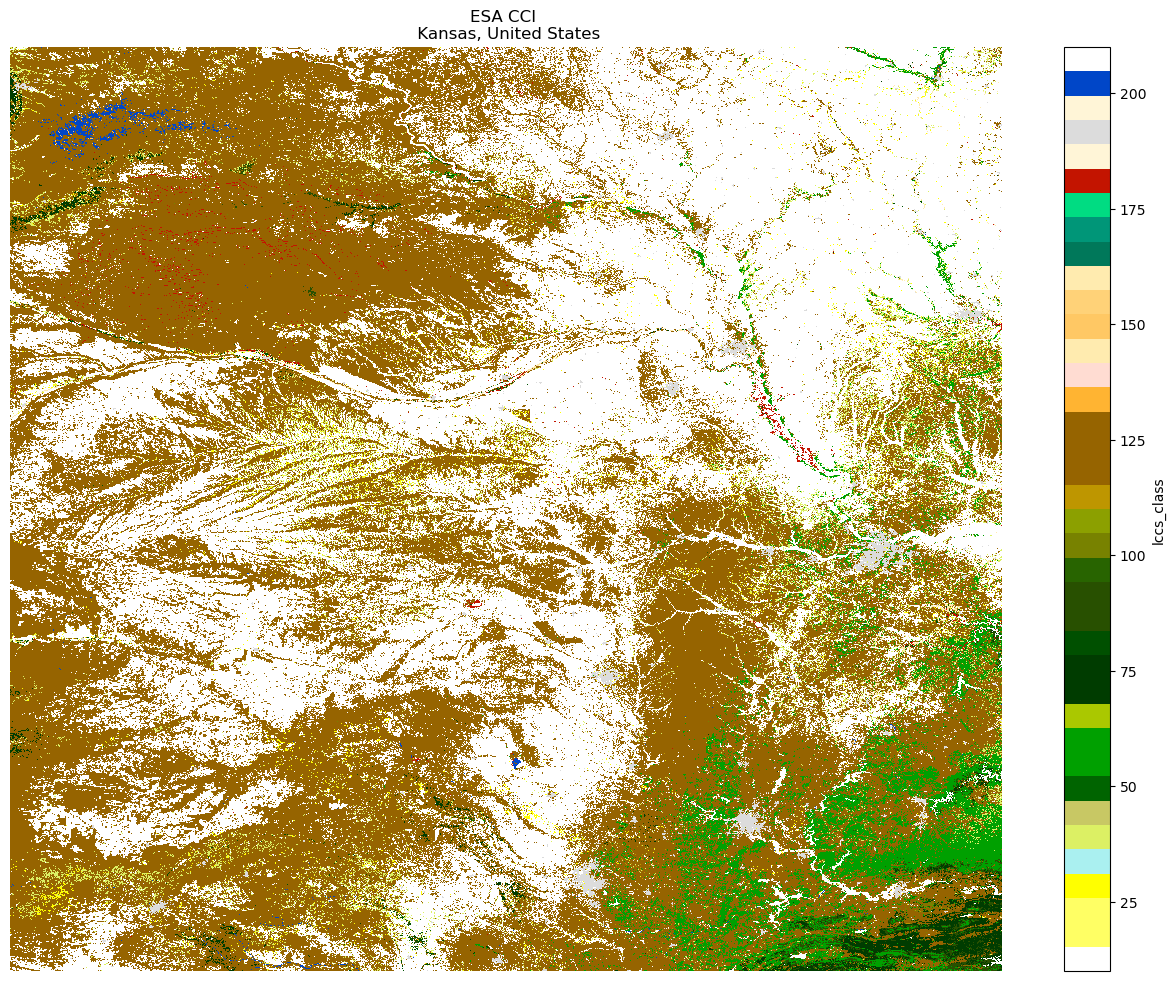

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 12))

p = (
    ds["lccs_class"]
    .isel(time=0)
    .plot(
        ax=ax,
        cmap=cmap,
    )
)

ax.set_axis_off()

ax.set_title("ESA CCI \n Kansas, United States")

colorbar = fig.axes[1]